In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import *
import pandas as pd
import re

We're going to do the freeCodeCamp's [sea level predictor project]("https://www.freecodecamp.org/learn/data-analysis-with-python/data-analysis-with-python-projects/sea-level-predictor") using pyspark.

In [2]:
spark = SparkSession.builder.appName('Practice').getOrCreate()

In [3]:
df= spark.read.csv('C:/Users/Andri/Python_Data/Prediction/epa-sea-level.csv', header=True, inferSchema=True)
df.show()

+----+------------------------+-----------------+-----------------+-----------------------+
|Year|CSIRO Adjusted Sea Level|Lower Error Bound|Upper Error Bound|NOAA Adjusted Sea Level|
+----+------------------------+-----------------+-----------------+-----------------------+
|1880|                     0.0|     -0.952755905|      0.952755905|                   null|
|1881|             0.220472441|     -0.732283464|      1.173228345|                   null|
|1882|            -0.440944881|     -1.346456692|      0.464566929|                   null|
|1883|            -0.232283464|     -1.129921259|       0.66535433|                   null|
|1884|             0.590551181|     -0.283464567|      1.464566928|                   null|
|1885|             0.531496062|     -0.330708661|      1.393700786|                   null|
|1886|             0.437007874|     -0.381889763|      1.255905511|                   null|
|1887|             0.216535433|     -0.602362204|       1.03543307|             

First, we rename the sea level column in order to make it code friendly. Then, we take the columns that we want and we make the first plot.

In order to make it scatter, we'll make a pandas dataframe with our selected columns and then we'll create our plot 

In [4]:
df = df.withColumnRenamed("CSIRO Adjusted Sea Level","CSIRO_Adjusted_Sea_Level")
df = df.select(['Year', 'CSIRO_Adjusted_Sea_Level'])

Text(0.5, 1.0, 'Rise in the sea level')

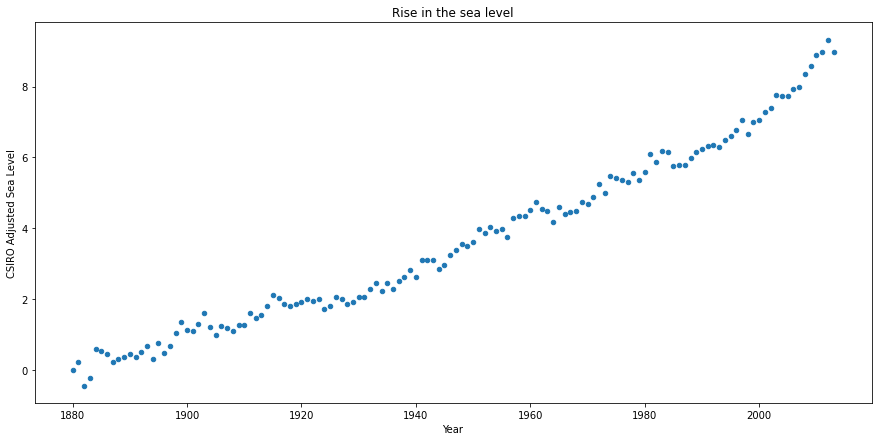

In [5]:
y = [i.CSIRO_Adjusted_Sea_Level for i in df.select('CSIRO_Adjusted_Sea_Level').collect()]
x = [i.Year for i in df.select('Year').collect()]
pandas = pd.DataFrame({'Year': x, 'CSIRO Adjusted Sea Level': y})
fig = pandas.plot(kind='scatter', x='Year', y='CSIRO Adjusted Sea Level', figsize=(15,7))
plt.title('Rise in the sea level')

Now we're going to make the first regression line. Since we're going to transform a lot of data in our way, we'll make a function in order to save some time and for future use.

In [6]:
def transform(data, independent_features, target_feature):
    #Vector
        featureassembler=VectorAssembler(inputCols=[independent_features], outputCol = "Independent_Features")
        #Transform
        output = featureassembler.transform(data)
        #Filtering
        finalized_data = output.select('Independent_Features', target_feature)
        return finalized_data 

In [7]:
train = transform(df, 'Year', 'CSIRO_Adjusted_Sea_Level')
train.show()

+--------------------+------------------------+
|Independent_Features|CSIRO_Adjusted_Sea_Level|
+--------------------+------------------------+
|            [1880.0]|                     0.0|
|            [1881.0]|             0.220472441|
|            [1882.0]|            -0.440944881|
|            [1883.0]|            -0.232283464|
|            [1884.0]|             0.590551181|
|            [1885.0]|             0.531496062|
|            [1886.0]|             0.437007874|
|            [1887.0]|             0.216535433|
|            [1888.0]|             0.299212598|
|            [1889.0]|             0.362204724|
|            [1890.0]|             0.440944881|
|            [1891.0]|             0.374015748|
|            [1892.0]|             0.499999999|
|            [1893.0]|             0.685039369|
|            [1894.0]|             0.303149606|
|            [1895.0]|             0.767716535|
|            [1896.0]|             0.468503937|
|            [1897.0]|             0.673

Now, we're going to make our regressor and we'll fit our data in.

In [8]:
regressor = LinearRegression(featuresCol='Independent_Features', labelCol='CSIRO_Adjusted_Sea_Level')
regressor = regressor.fit(train)

Now, we need to extend our line to the year 2050. In order to do that, we'll make another dataframe starting from 2014(since our data end in 2013), we'll transform it, we'll unionize it with the train dataframe, we'll do the evaluation, we'll drop the CSIRO_Adjusted_Sea_Level column, and then we'll have the exact columns that we need for our plot.

In [9]:
df2 = spark.range(2014,2051).withColumnRenamed("id","Year").withColumn("CSIRO_Adjusted_Sea_Level",lit(0.0))
df2 = transform(df2, 'Year', 'CSIRO_Adjusted_Sea_Level')
df_pred = train.union(df2)
df_pred

DataFrame[Independent_Features: vector, CSIRO_Adjusted_Sea_Level: double]

In [10]:
pred_result = regressor.evaluate(df_pred)
pred_result.predictions.show()

+--------------------+------------------------+--------------------+
|Independent_Features|CSIRO_Adjusted_Sea_Level|          prediction|
+--------------------+------------------------+--------------------+
|            [1880.0]|                     0.0| -0.5421240249244192|
|            [1881.0]|             0.220472441|-0.47907944091231514|
|            [1882.0]|            -0.440944881|  -0.416034856900211|
|            [1883.0]|            -0.232283464| -0.3529902728880927|
|            [1884.0]|             0.590551181| -0.2899456888759886|
|            [1885.0]|             0.531496062|-0.22690110486388448|
|            [1886.0]|             0.437007874|-0.16385652085178037|
|            [1887.0]|             0.216535433|-0.10081193683967626|
|            [1888.0]|             0.299212598|-0.03776735282757...|
|            [1889.0]|             0.362204724|0.025277231184531956|
|            [1890.0]|             0.440944881| 0.08832181519663607|
|            [1891.0]|            

In [11]:
pred_result = pred_result.predictions.drop('CSIRO_Adjusted_Sea_Level')

In [12]:
pred_result.show()

+--------------------+--------------------+
|Independent_Features|          prediction|
+--------------------+--------------------+
|            [1880.0]| -0.5421240249244192|
|            [1881.0]|-0.47907944091231514|
|            [1882.0]|  -0.416034856900211|
|            [1883.0]| -0.3529902728880927|
|            [1884.0]| -0.2899456888759886|
|            [1885.0]|-0.22690110486388448|
|            [1886.0]|-0.16385652085178037|
|            [1887.0]|-0.10081193683967626|
|            [1888.0]|-0.03776735282757...|
|            [1889.0]|0.025277231184531956|
|            [1890.0]| 0.08832181519663607|
|            [1891.0]| 0.15136639920874018|
|            [1892.0]|  0.2144109832208443|
|            [1893.0]|  0.2774555672329484|
|            [1894.0]|  0.3405001512450667|
|            [1895.0]| 0.40354473525717083|
|            [1896.0]| 0.46658931926927494|
|            [1897.0]|   0.529633903281379|
|            [1898.0]|  0.5926784872934832|
|            [1899.0]|  0.655723

Now, we can make our plot. To begin with, we'll make our dataframes for plotting.

In [13]:
#Original dataframe
y_axis = [i.CSIRO_Adjusted_Sea_Level for i in df.select('CSIRO_Adjusted_Sea_Level').collect()]
x_axis = [i.Year for i in df.select('Year').collect()]
scatter_df = pd.DataFrame({'Year': x, 'CSIRO Adjusted Sea Level': y})

#linear prediction dataframe
y = [i.prediction for i in pred_result.select('prediction').collect()]

line1_df = pd.DataFrame({'Year': pd.Series(np.arange(1880, 2051)),
                        'CSIRO Adjusted Sea Level': y})

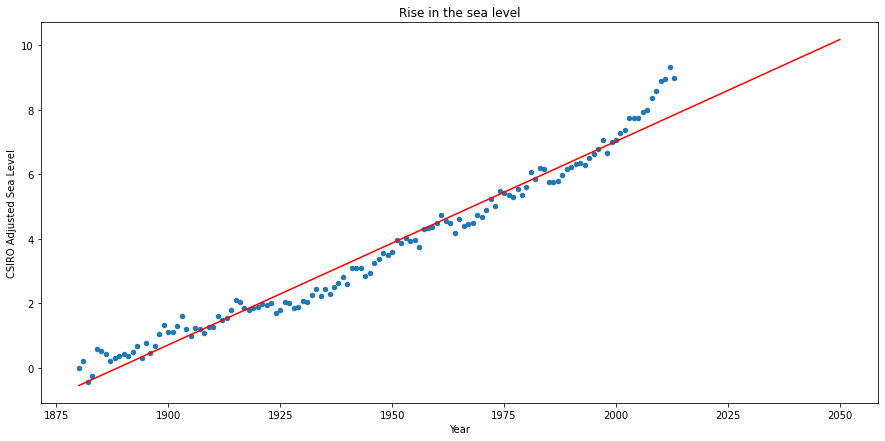

In [14]:
fig = scatter_df.plot(kind='scatter', x='Year', y='CSIRO Adjusted Sea Level', figsize=(15,7))
plt.title('Rise in the sea level')
x = pd.Series(np.arange(1880, 2051))
y = line1_df['CSIRO Adjusted Sea Level']
plt.plot(x, y, 'r')

Now, we need to make a third dataframe for making a line that predicts the sea level rise in 2050 if the rate of rise continues as it has since the year 2000.

In [15]:
df_filtered = df.filter(df.Year >=2000)
train = transform(df_filtered, 'Year', 'CSIRO_Adjusted_Sea_Level')

regressor = LinearRegression(featuresCol='Independent_Features', labelCol='CSIRO_Adjusted_Sea_Level')
regressor = regressor.fit(train)


df_pred = train.union(df2)

pred_result = regressor.evaluate(df_pred)
pred_result = pred_result.predictions.drop('CSIRO_Adjusted_Sea_Level')

sea_level = [i.prediction for i in pred_result.select('prediction').collect()]

line2_df = pd.DataFrame({'Year': pd.Series(np.arange(2000, 2051)),
                        'CSIRO Adjusted Sea Level': sea_level})

line2_df.head()

,Year,CSIRO Adjusted Sea Level
0,2000,7.061080
1,2001,7.227507
2,2002,7.393934
3,2003,7.560362
4,2004,7.726789


Now we can make our final plot.

Text(0.5, 1.0, 'Rise in the sea level')

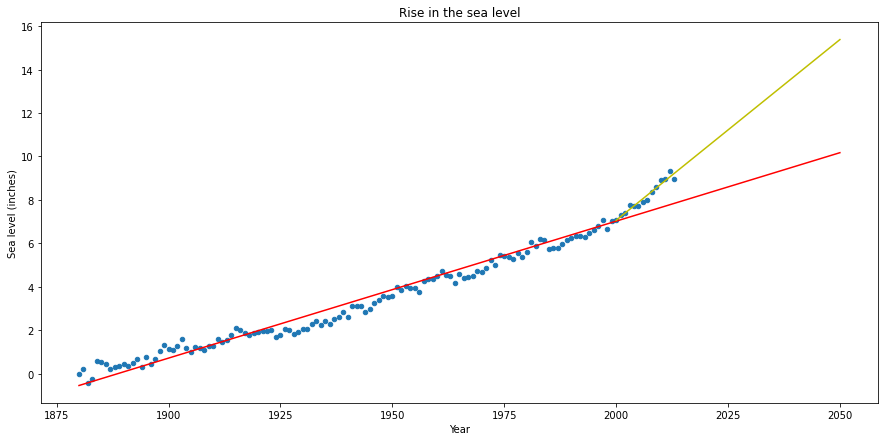

In [16]:
fig = scatter_df.plot(kind='scatter', x='Year', y='CSIRO Adjusted Sea Level', figsize=(15,7))
plt.title('Rise in the sea level')
x = pd.Series(np.arange(1880, 2051))
y = line1_df['CSIRO Adjusted Sea Level']
plt.plot(x, y, 'r')
x = pd.Series(np.arange(2000, 2051))
y = line2_df['CSIRO Adjusted Sea Level']
plt.plot(x, y, 'y')
fig.set_ylabel('Sea level (inches)')
fig.set_xlabel('Year')
fig.set_title('Rise in the sea level')